## Neural network to predict when to buy, sell or hold a stock

Here we are going to build a prediction algorithm to tell us when to buy, sell or hold a stock. This prediction task has been set up in such a way that the algorithm will make a buy/sell/hold prediction once every day. The data which we'll use are the historical prices of *Netflix* stock dating back to 2002. We'll build a sequential neural network using *Keras* and *Tensorflow*, as well as *Pandas* and *Numpy* for handling the data and doing some computtions.

### Import historical price data

Import data using pandas and convert the columns to the appropriate data types.

In [1]:
import pandas as pd
pd.set_option("display.max_rows",10)
pd.set_option("display.max_columns",100)
NtflxData = pd.read_csv("NFLX.csv")
print("The data types in our table are:")
display(NtflxData.dtypes)
print ("### Changing index to 'date' ###")
NtflxData['Date'] = pd.to_datetime(NtflxData['Date'])
NtflxData = NtflxData.set_index('Date')
display(NtflxData)

The data types in our table are:


Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

### Changing index to 'date' ###


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200.0
...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,9669000.0
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,9123600.0
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0


We'll also import *S&P500* data to use as feature. The *S&P500* index should tell us the overall market trend, which might impact the our stock of interest.

*Note: We are actually using IVV index fund here because it mimicks the actual S&P500 index, and was easily obtainable.*

In [2]:
### import S&P 500 data
IVVData = pd.read_csv('IVV.csv')
IVVData['Date'] = pd.to_datetime(IVVData['Date'])
IVVData = IVVData.set_index('Date')
display(IVVData)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,100.833214,775500
2000-05-22,140.593750,140.593750,136.812500,139.812500,100.206131,1850600
2000-05-23,140.218750,140.218750,137.687500,137.687500,98.683067,373900
2000-05-24,137.750000,140.062500,136.656250,139.750000,100.161354,400300
2000-05-25,140.031250,140.937500,137.875000,138.468750,99.243027,69600
...,...,...,...,...,...,...
2018-02-12,265.670013,268.929993,263.820007,267.179993,267.179993,6801400
2018-02-13,265.899994,268.559998,265.239990,267.959991,267.959991,4210500
2018-02-14,266.359985,271.980011,266.220001,271.649994,271.649994,6380400


#### Add some features

Some features extracted from the *date* will be added here. Additionally, we'll also add the *close price of next day* from which the exact *target* will be extracted.

In [3]:
import numpy as np
NtflxData = NtflxData[pd.notnull(NtflxData['Close'])]
NtflxData['NextDayClose'] = np.nan
NtflxData['NextDayClose'][0:(len(NtflxData)-1)] = NtflxData['Close'][1:len(NtflxData)]
NtflxData['Day'] = NtflxData.index.day
NtflxData['Month'] = NtflxData.index.month
NtflxData['Year'] = NtflxData.index.year
NtflxData['DayofWeek'] = NtflxData.index.dayofweek
NtflxData['DayofYear'] = NtflxData.index.dayofyear
display(NtflxData)

#### Now for S&P 500

IVVData = IVVData[pd.notnull(IVVData['Close'])]
IVVData['NextDayClose'] = np.nan
IVVData['NextDayClose'][0:(len(IVVData)-1)] = IVVData['Close'][1:len(IVVData)]
IVVData['Day'] = IVVData.index.day
IVVData['Month'] = IVVData.index.month
IVVData['Year'] = IVVData.index.year
IVVData['DayofWeek'] = IVVData.index.dayofweek
IVVData['DayofYear'] = IVVData.index.dayofyear
display(IVVData)

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear
Date,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0,1.210000,23,5,2002,3,143
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.157143,24,5,2002,4,144
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0,1.103571,28,5,2002,1,148
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0,1.071429,29,5,2002,2,149
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200.0,1.076429,30,5,2002,3,150
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,9669000.0,267.429993,1,2,2018,3,32
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,9123600.0,254.259995,2,2,2018,4,33
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0,265.720001,5,2,2018,0,36


/home/ubuntu/anaconda3/envs/StockPredict/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear
Date,,,,,,,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,100.833214,775500,139.812500,19,5,2000,4,140
2000-05-22,140.593750,140.593750,136.812500,139.812500,100.206131,1850600,137.687500,22,5,2000,0,143
2000-05-23,140.218750,140.218750,137.687500,137.687500,98.683067,373900,139.750000,23,5,2000,1,144
2000-05-24,137.750000,140.062500,136.656250,139.750000,100.161354,400300,138.468750,24,5,2000,2,145
2000-05-25,140.031250,140.937500,137.875000,138.468750,99.243027,69600,137.843750,25,5,2000,3,146
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-12,265.670013,268.929993,263.820007,267.179993,267.179993,6801400,267.959991,12,2,2018,0,43
2018-02-13,265.899994,268.559998,265.239990,267.959991,267.959991,4210500,271.649994,13,2,2018,1,44
2018-02-14,266.359985,271.980011,266.220001,271.649994,271.649994,6380400,275.019989,14,2,2018,2,45


Here the actual *target* feature will be extracted. Essentially, if the next day's *Percent Change in Closing Price* is larger than +1, then it is considered a strong *buy* signal. On the other hand, if it is less than -1, then it is considered a strong sell signal. Anything between -1 and +1 is considered a weak price movement for which the signal will be *hold*.

In [4]:
NtflxData['NextDayPrcntChange'] = (NtflxData['NextDayClose'] - NtflxData['Close']) / NtflxData['Close']
NtflxData['NextDayPrcntChangeBinned'] = np.zeros(len(NtflxData))
NtflxData['NextDayPrcntChangeBinned'][(NtflxData['NextDayPrcntChange'] > 0.01)] = 1
NtflxData['NextDayPrcntChangeBinned'][(NtflxData['NextDayPrcntChange'] < -0.01)] = -1
NtflxData['S.No.'] = range(len(NtflxData))
display(NtflxData)



/home/ubuntu/anaconda3/envs/StockPredict/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/envs/StockPredict/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.
Date,,,,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0,1.210000,23,5,2002,3,143,0.011343,1.0,0
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.157143,24,5,2002,4,144,-0.043683,-1.0,1
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0,1.103571,28,5,2002,1,148,-0.046297,-1.0,2
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0,1.071429,29,5,2002,2,149,-0.029125,-1.0,3
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200.0,1.076429,30,5,2002,3,150,0.004667,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,9669000.0,267.429993,1,2,2018,3,32,0.008903,0.0,3951
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,9123600.0,254.259995,2,2,2018,4,33,-0.049247,-1.0,3952
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0,265.720001,5,2,2018,0,36,0.045072,1.0,3953


We'll now plot the *target* variable to make sure it is evenly spread throughout the table, as well as to make sure all the three possible target classes are equally represented.

The first plot shows that all the three target classes are evenly distributed across the table.

/home/ubuntu/anaconda3/envs/StockPredict/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


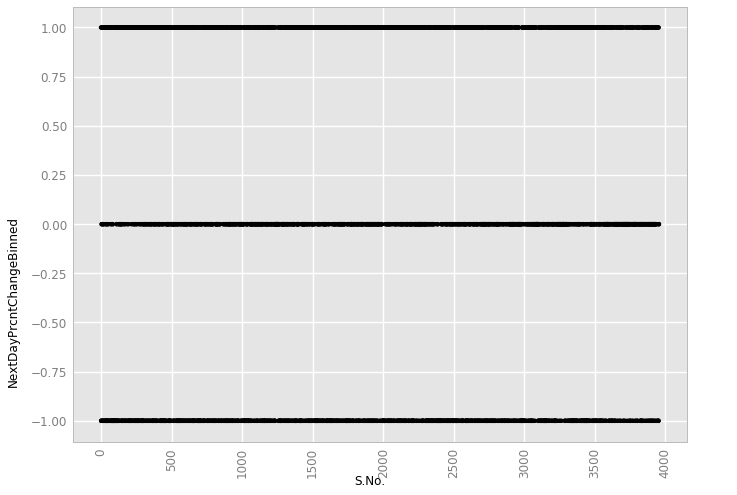

<ggplot: (8742455934966)>

In [5]:
from ggplot import *
p1 = ggplot(aes(x='S.No.', y='NextDayPrcntChangeBinned'), data=NtflxData)
p1 = p1 + geom_point() + theme(axis_text_x = element_text(angle=90))
p1

The following plot shows that all the three target classes are approximately equaly represented. This would prevent the NN from simply predicting the most frequent target class more often.

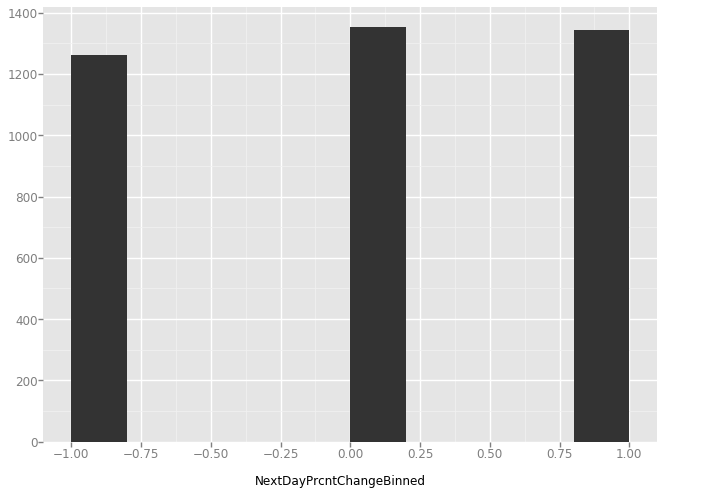

<ggplot: (8742455934889)>

In [6]:
p2 = ggplot(aes('NextDayPrcntChangeBinned'), data=NtflxData)
p2 = p2 + geom_histogram()
p2

Now we'll add *trend* features to know which way are the prices/market heading in the short as well as long term.

Add percent chnage in a given window.

In [7]:
ChangeDays = [1,2,3,5,7,14,30,60,90,120]
for CurrentDay in ChangeDays:
    NewColName = 'PCntChng{0}Days'.format(CurrentDay)
    NtflxData[NewColName] = NtflxData['Close'].pct_change(periods=CurrentDay)
    IVVData[NewColName] = IVVData['Close'].pct_change(periods=CurrentDay)

Add percent above/below rolling window mean

In [8]:
ChangeDays = [2,3,5,7,14,30,60,90,120]
for CurrentDay in ChangeDays:
    NewColName = 'CloseRolled{0}Day_DiffPer'.format(CurrentDay)
    NtflxData[NewColName] = (NtflxData['Close'] - NtflxData['Close'].rolling(window=CurrentDay).mean()) / NtflxData['Close'].rolling(window=CurrentDay).mean()
    IVVData[NewColName] = (IVVData['Close'] - IVVData['Close'].rolling(window=CurrentDay).mean()) / IVVData['Close'].rolling(window=CurrentDay).mean()

Add percent above/below rolling Volume mean

In [9]:
ChangeDays = [2,3,5,7,14,30]
for CurrentDay in ChangeDays:
    NewColName = 'VolumeRolled{0}Day_DiffPer'.format(CurrentDay)
    NtflxData[NewColName] = (NtflxData['Volume'] - NtflxData['Volume'].rolling(window=CurrentDay).mean()) / NtflxData['Volume'].rolling(window=CurrentDay).mean()
    IVVData[NewColName] = (IVVData['Volume'] - IVVData['Volume'].rolling(window=CurrentDay).mean()) / IVVData['Volume'].rolling(window=CurrentDay).mean()

In [10]:
display(NtflxData)
display(IVVData)

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days,PCntChng2Days,PCntChng3Days,PCntChng5Days,PCntChng7Days,PCntChng14Days,PCntChng30Days,PCntChng60Days,PCntChng90Days,PCntChng120Days,CloseRolled2Day_DiffPer,CloseRolled3Day_DiffPer,CloseRolled5Day_DiffPer,CloseRolled7Day_DiffPer,CloseRolled14Day_DiffPer,CloseRolled30Day_DiffPer,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000.0,1.210000,23,5,2002,3,143,0.011343,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800.0,1.157143,24,5,2002,4,144,-0.043683,-1.0,1,0.011343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.808364,NaN,NaN,NaN,NaN,NaN
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400.0,1.103571,28,5,2002,1,148,-0.046297,-1.0,2,-0.043683,-0.032836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022329,-0.025857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.253774,-0.838143,NaN,NaN,NaN,NaN
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800.0,1.071429,29,5,2002,2,149,-0.029125,-1.0,3,-0.046297,-0.087958,-0.077613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023697,-0.046100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011102,-0.171568,NaN,NaN,NaN,NaN
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200.0,1.076429,30,5,2002,3,150,0.004667,0.0,4,-0.029125,-0.074074,-0.114521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014778,-0.035369,-0.066467,NaN,NaN,NaN,NaN,NaN,NaN,0.200828,0.295101,-0.635831,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,9669000.0,267.429993,1,2,2018,3,32,0.008903,0.0,3951,-0.019349,-0.049247,-0.068590,-0.017167,0.059052,0.220171,0.392028,0.325284,0.414839,0.567163,-0.009769,-0.023287,-0.034958,-0.025662,0.065369,0.192360,0.280986,0.311580,0.355947,-0.094837,-0.142996,-0.225222,-0.288201,-0.287954,-0.008567
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,9123600.0,254.259995,2,2,2018,4,33,-0.049247,-1.0,3952,0.008903,-0.010618,-0.040782,-0.026111,0.023460,0.208832,0.429954,0.336281,0.497788,0.560268,0.004432,-0.000635,-0.021256,-0.020141,0.060785,0.188645,0.285423,0.316823,0.362442,-0.029022,-0.102235,-0.245987,-0.264721,-0.331369,-0.071128
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0,265.720001,5,2,2018,0,36,0.045072,1.0,3953,-0.049247,-0.040782,-0.059341,-0.106574,-0.057249,0.147745,0.346573,0.297973,0.417438,0.486901,-0.025245,-0.030479,-0.048328,-0.060806,-0.000721,0.119256,0.216433,0.246866,0.290784,0.131900,0.162913,0.084091,-0.001744,-0.120727,0.189539


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,PCntChng1Days,PCntChng2Days,PCntChng3Days,PCntChng5Days,PCntChng7Days,PCntChng14Days,PCntChng30Days,PCntChng60Days,PCntChng90Days,PCntChng120Days,CloseRolled2Day_DiffPer,CloseRolled3Day_DiffPer,CloseRolled5Day_DiffPer,CloseRolled7Day_DiffPer,CloseRolled14Day_DiffPer,CloseRolled30Day_DiffPer,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,100.833214,775500,139.812500,19,5,2000,4,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-22,140.593750,140.593750,136.812500,139.812500,100.206131,1850600,137.687500,22,5,2000,0,143,-0.006219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.409390,NaN,NaN,NaN,NaN,NaN
2000-05-23,140.218750,140.218750,137.687500,137.687500,98.683067,373900,139.750000,23,5,2000,1,144,-0.015199,-0.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007658,-0.012255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.663835,-0.626100,NaN,NaN,NaN,NaN
2000-05-24,137.750000,140.062500,136.656250,139.750000,100.161354,400300,138.468750,24,5,2000,2,145,0.014980,-0.000447,-0.006664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007434,0.004793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034100,-0.542479,NaN,NaN,NaN,NaN
2000-05-25,140.031250,140.937500,137.875000,138.468750,99.243027,69600,137.843750,25,5,2000,3,146,-0.009168,0.005674,-0.009611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004605,-0.001202,-0.005834,NaN,NaN,NaN,NaN,NaN,NaN,-0.703767,-0.752548,-0.899709,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-12,265.670013,268.929993,263.820007,267.179993,267.179993,6801400,267.959991,12,2,2018,0,43,0.013312,0.029119,-0.008940,0.004247,-0.058529,-0.063807,-0.009674,0.029278,0.049534,0.092359,0.006612,0.014004,0.003440,-0.002475,-0.034079,-0.035988,-0.015982,0.000430,0.016435,-0.378359,-0.350970,-0.401763,-0.392786,-0.170687,0.116992
2018-02-13,265.899994,268.559998,265.239990,267.959991,267.959991,4210500,271.649994,13,2,2018,1,44,0.002919,0.016270,0.032124,-0.012166,-0.034483,-0.060581,-0.003310,0.037881,0.051236,0.084858,0.001458,0.006347,0.008870,0.005570,-0.026917,-0.033071,-0.013701,0.002805,0.018725,-0.235282,-0.515897,-0.531829,-0.610980,-0.482368,-0.311683
2018-02-14,266.359985,271.980011,266.220001,271.649994,271.649994,6380400,275.019989,14,2,2018,2,45,0.013771,0.016730,0.030265,0.007641,0.021049,-0.048011,0.002954,0.043443,0.059560,0.103595,0.006838,0.010114,0.021179,0.016366,-0.009999,-0.019850,-0.000812,0.015970,0.031920,0.204883,0.100556,-0.240951,-0.337704,-0.231569,0.055495


Here we'll scale and normalize the appropriate features to prepare them as inputs to our model.

In [11]:
CategoricalFeatures = NtflxData.columns[[8,9,10]]
for CurrentColumn in CategoricalFeatures:
    NtflxData[CurrentColumn] = NtflxData[CurrentColumn].astype('category')
    NtflxData[CurrentColumn] = NtflxData[CurrentColumn].cat.codes
    IVVData[CurrentColumn] = IVVData[CurrentColumn].astype('category')
    IVVData[CurrentColumn] = IVVData[CurrentColumn].cat.codes


### Normalize Volume #####

NtflxData['Volume'] = np.log1p(NtflxData['Volume'])
NtflxData['Volume'] = (NtflxData['Volume'] - np.min(NtflxData['Volume'])) / (np.max(NtflxData['Volume'] - np.min(NtflxData['Volume'])))

IVVData['Volume'] = np.log1p(IVVData['Volume'])
IVVData['Volume'] = (IVVData['Volume'] - np.min(IVVData['Volume'])) / (np.max(IVVData['Volume'] - np.min(IVVData['Volume'])))

display (NtflxData)
display (IVVData)

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days,PCntChng2Days,PCntChng3Days,PCntChng5Days,PCntChng7Days,PCntChng14Days,PCntChng30Days,PCntChng60Days,PCntChng90Days,PCntChng120Days,CloseRolled2Day_DiffPer,CloseRolled3Day_DiffPer,CloseRolled5Day_DiffPer,CloseRolled7Day_DiffPer,CloseRolled14Day_DiffPer,CloseRolled30Day_DiffPer,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,0.839738,1.210000,23,4,0,3,143,0.011343,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,0.520547,1.157143,24,4,0,4,144,-0.043683,-1.0,1,0.011343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.808364,NaN,NaN,NaN,NaN,NaN
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,0.446759,1.103571,28,4,0,1,148,-0.046297,-1.0,2,-0.043683,-0.032836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022329,-0.025857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.253774,-0.838143,NaN,NaN,NaN,NaN
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,0.449917,1.071429,29,4,0,2,149,-0.029125,-1.0,3,-0.046297,-0.087958,-0.077613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023697,-0.046100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011102,-0.171568,NaN,NaN,NaN,NaN
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,0.507821,1.076429,30,4,0,3,150,0.004667,0.0,4,-0.029125,-0.074074,-0.114521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014778,-0.035369,-0.066467,NaN,NaN,NaN,NaN,NaN,NaN,0.200828,0.295101,-0.635831,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,0.500859,267.429993,1,1,16,3,32,0.008903,0.0,3951,-0.019349,-0.049247,-0.068590,-0.017167,0.059052,0.220171,0.392028,0.325284,0.414839,0.567163,-0.009769,-0.023287,-0.034958,-0.025662,0.065369,0.192360,0.280986,0.311580,0.355947,-0.094837,-0.142996,-0.225222,-0.288201,-0.287954,-0.008567
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,0.492602,254.259995,2,1,16,4,33,-0.049247,-1.0,3952,0.008903,-0.010618,-0.040782,-0.026111,0.023460,0.208832,0.429954,0.336281,0.497788,0.560268,0.004432,-0.000635,-0.021256,-0.020141,0.060785,0.188645,0.285423,0.316823,0.362442,-0.029022,-0.102235,-0.245987,-0.264721,-0.331369,-0.071128
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,0.530336,265.720001,5,1,16,0,36,0.045072,1.0,3953,-0.049247,-0.040782,-0.059341,-0.106574,-0.057249,0.147745,0.346573,0.297973,0.417438,0.486901,-0.025245,-0.030479,-0.048328,-0.060806,-0.000721,0.119256,0.216433,0.246866,0.290784,0.131900,0.162913,0.084091,-0.001744,-0.120727,0.189539


,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,PCntChng1Days,PCntChng2Days,PCntChng3Days,PCntChng5Days,PCntChng7Days,PCntChng14Days,PCntChng30Days,PCntChng60Days,PCntChng90Days,PCntChng120Days,CloseRolled2Day_DiffPer,CloseRolled3Day_DiffPer,CloseRolled5Day_DiffPer,CloseRolled7Day_DiffPer,CloseRolled14Day_DiffPer,CloseRolled30Day_DiffPer,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,100.833214,0.550053,139.812500,19,4,0,4,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-22,140.593750,140.593750,136.812500,139.812500,100.206131,0.650107,137.687500,22,4,0,0,143,-0.006219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.409390,NaN,NaN,NaN,NaN,NaN
2000-05-23,140.218750,140.218750,137.687500,137.687500,98.683067,0.466132,139.750000,23,4,0,1,144,-0.015199,-0.021324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007658,-0.012255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.663835,-0.626100,NaN,NaN,NaN,NaN
2000-05-24,137.750000,140.062500,136.656250,139.750000,100.161354,0.473980,138.468750,24,4,0,2,145,0.014980,-0.000447,-0.006664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007434,0.004793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034100,-0.542479,NaN,NaN,NaN,NaN
2000-05-25,140.031250,140.937500,137.875000,138.468750,99.243027,0.272731,137.843750,25,4,0,3,146,-0.009168,0.005674,-0.009611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004605,-0.001202,-0.005834,NaN,NaN,NaN,NaN,NaN,NaN,-0.703767,-0.752548,-0.899709,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-12,265.670013,268.929993,263.820007,267.179993,267.179993,0.799841,267.959991,12,1,18,0,43,0.013312,0.029119,-0.008940,0.004247,-0.058529,-0.063807,-0.009674,0.029278,0.049534,0.092359,0.006612,0.014004,0.003440,-0.002475,-0.034079,-0.035988,-0.015982,0.000430,0.016435,-0.378359,-0.350970,-0.401763,-0.392786,-0.170687,0.116992
2018-02-13,265.899994,268.559998,265.239990,267.959991,267.959991,0.744675,271.649994,13,1,18,1,44,0.002919,0.016270,0.032124,-0.012166,-0.034483,-0.060581,-0.003310,0.037881,0.051236,0.084858,0.001458,0.006347,0.008870,0.005570,-0.026917,-0.033071,-0.013701,0.002805,0.018725,-0.235282,-0.515897,-0.531829,-0.610980,-0.482368,-0.311683
2018-02-14,266.359985,271.980011,266.220001,271.649994,271.649994,0.792490,275.019989,14,1,18,2,45,0.013771,0.016730,0.030265,0.007641,0.021049,-0.048011,0.002954,0.043443,0.059560,0.103595,0.006838,0.010114,0.021179,0.016366,-0.009999,-0.019850,-0.000812,0.015970,0.031920,0.204883,0.100556,-0.240951,-0.337704,-0.231569,0.055495


Now we need to merge the two dataframes, *Netflix* and *S&P500*.

In [12]:
CombinedDF = NtflxData.join(IVVData[['PCntChng1Days','PCntChng2Days','PCntChng3Days','PCntChng5Days','PCntChng7Days','PCntChng14Days','PCntChng30Days','PCntChng60Days','PCntChng90Days','PCntChng120Days','CloseRolled2Day_DiffPer','CloseRolled3Day_DiffPer','CloseRolled5Day_DiffPer','CloseRolled7Day_DiffPer','CloseRolled14Day_DiffPer','CloseRolled30Day_DiffPer']], lsuffix='_Ntflx', rsuffix='_SP500')
display(CombinedDF)

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days_Ntflx,PCntChng2Days_Ntflx,PCntChng3Days_Ntflx,PCntChng5Days_Ntflx,PCntChng7Days_Ntflx,PCntChng14Days_Ntflx,PCntChng30Days_Ntflx,PCntChng60Days_Ntflx,PCntChng90Days_Ntflx,PCntChng120Days_Ntflx,CloseRolled2Day_DiffPer_Ntflx,CloseRolled3Day_DiffPer_Ntflx,CloseRolled5Day_DiffPer_Ntflx,CloseRolled7Day_DiffPer_Ntflx,CloseRolled14Day_DiffPer_Ntflx,CloseRolled30Day_DiffPer_Ntflx,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer,PCntChng1Days_SP500,PCntChng2Days_SP500,PCntChng3Days_SP500,PCntChng5Days_SP500,PCntChng7Days_SP500,PCntChng14Days_SP500,PCntChng30Days_SP500,PCntChng60Days_SP500,PCntChng90Days_SP500,PCntChng120Days_SP500,CloseRolled2Day_DiffPer_SP500,CloseRolled3Day_DiffPer_SP500,CloseRolled5Day_DiffPer_SP500,CloseRolled7Day_DiffPer_SP500,CloseRolled14Day_DiffPer_SP500,CloseRolled30Day_DiffPer_SP500
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,0.839738,1.210000,23,4,0,3,143,0.011343,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009995,0.014461,0.003554,-0.001632,-0.000454,0.023321,-0.005328,-0.013348,-0.035721,-0.036648,0.004973,0.008116,0.004066,0.003527,0.014835,0.006844
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,0.520547,1.157143,24,4,0,4,144,-0.043683,-1.0,1,0.011343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.808364,NaN,NaN,NaN,NaN,NaN,-0.012620,-0.002751,0.001658,-0.019917,-0.006668,0.030220,-0.024051,-0.020623,-0.055169,-0.046722,-0.006350,-0.005153,-0.004595,-0.008195,-0.000072,-0.005050
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,0.446759,1.103571,28,4,0,1,148,-0.046297,-1.0,2,-0.043683,-0.032836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022329,-0.025857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.253774,-0.838143,NaN,NaN,NaN,NaN,-0.006989,-0.019521,-0.009720,-0.016036,-0.021120,0.027791,-0.024040,-0.050721,-0.042642,-0.047035,-0.003507,-0.008902,-0.008356,-0.012127,-0.008961,-0.011201
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,0.449917,1.071429,29,4,0,2,149,-0.029125,-1.0,3,-0.046297,-0.087958,-0.077613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023697,-0.046100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011102,-0.171568,NaN,NaN,NaN,NaN,-0.007316,-0.014253,-0.026693,-0.012619,-0.033886,-0.016514,-0.052669,-0.073226,-0.056919,-0.069202,-0.003671,-0.007224,-0.013128,-0.014512,-0.015049,-0.016646
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,0.507821,1.076429,30,4,0,3,150,0.004667,0.0,4,-0.029125,-0.074074,-0.114521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014778,-0.035369,-0.066467,NaN,NaN,NaN,NaN,NaN,NaN,0.200828,0.295101,-0.635831,NaN,NaN,NaN,-0.000840,-0.008149,-0.015080,-0.017790,-0.024055,-0.005478,-0.052375,-0.071837,-0.052627,-0.088037,-0.000420,-0.003010,-0.010421,-0.011913,-0.015494,-0.015690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,266.410004,271.950012,263.380005,265.070007,265.070007,0.500859,267.429993,1,1,16,3,32,0.008903,0.0,3951,-0.019349,-0.049247,-0.068590,-0.017167,0.059052,0.220171,0.392028,0.325284,0.414839,0.567163,-0.009769,-0.023287,-0.034958,-0.025662,0.065369,0.192360,0.280986,0.311580,0.355947,-0.094837,-0.142996,-0.225222,-0.288201,-0.287954,-0.008567,-0.001267,0.000494,-0.010323,-0.005467,-0.005606,0.020497,0.045383,0.090745,0.124500,0.156109,-0.000634,-0.000258,-0.005641,-0.005537,0.000279,0.022662
2018-02-02,263.000000,270.619995,262.709991,267.429993,267.429993,0.492602,254.259995,2,1,16,4,33,-0.049247,-1.0,395

### Build model

Now we are ready to start building our model.

But first, we'll remove *NANs* from the dataframe to prevent difficulties later. Then we'll split the entire data randomly into *Training* and two separate *Testing* data.

In [13]:
for CurrentColumn in CombinedDF.columns:
    RowsWithNAN = ~np.isnan(CombinedDF[CurrentColumn])
    CombinedDF = CombinedDF[RowsWithNAN]

    TrainIndices = np.random.randint(low=0, high = int(len(CombinedDF)), size = round(0.2*int(len(CombinedDF))))
TrainIndicesBoolean = pd.Series(range(len(CombinedDF)), copy=True).isin(TrainIndices)
MyTest_1 = pd.DataFrame(CombinedDF[TrainIndicesBoolean.values], copy=True)
TrainIndicesBoolean = ~pd.Series(range(len(CombinedDF)), copy=True).isin(TrainIndices)
MyTrain = pd.DataFrame(CombinedDF[TrainIndicesBoolean.values], copy=True)
##### Now the second Tets data #####
TrainIndicesBoolean = pd.Series(range(len(CombinedDF)), copy=True).isin(TrainIndices)
MyTest_2 = pd.DataFrame(CombinedDF[TrainIndicesBoolean.values], copy=True)
TrainIndicesBoolean = ~pd.Series(range(len(CombinedDF)), copy=True).isin(TrainIndices)
MyTrain = pd.DataFrame(CombinedDF[TrainIndicesBoolean.values], copy=True)
pd.options.display.max_columns = None
pd.set_option("display.max_rows",10)
display(MyTrain)
display(MyTest_1)
display(MyTest_2)

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days_Ntflx,PCntChng2Days_Ntflx,PCntChng3Days_Ntflx,PCntChng5Days_Ntflx,PCntChng7Days_Ntflx,PCntChng14Days_Ntflx,PCntChng30Days_Ntflx,PCntChng60Days_Ntflx,PCntChng90Days_Ntflx,PCntChng120Days_Ntflx,CloseRolled2Day_DiffPer_Ntflx,CloseRolled3Day_DiffPer_Ntflx,CloseRolled5Day_DiffPer_Ntflx,CloseRolled7Day_DiffPer_Ntflx,CloseRolled14Day_DiffPer_Ntflx,CloseRolled30Day_DiffPer_Ntflx,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer,PCntChng1Days_SP500,PCntChng2Days_SP500,PCntChng3Days_SP500,PCntChng5Days_SP500,PCntChng7Days_SP500,PCntChng14Days_SP500,PCntChng30Days_SP500,PCntChng60Days_SP500,PCntChng90Days_SP500,PCntChng120Days_SP500,CloseRolled2Day_DiffPer_SP500,CloseRolled3Day_DiffPer_SP500,CloseRolled5Day_DiffPer_SP500,CloseRolled7Day_DiffPer_SP500,CloseRolled14Day_DiffPer_SP500,CloseRolled30Day_DiffPer_SP500
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-11-12,0.600000,0.614286,0.572143,0.577857,0.577857,0.289746,0.641429,12,10,0,1,316,0.110013,1.0,120,-0.038050,-0.053801,-0.025301,-0.112939,-0.095078,-0.019395,-0.148421,-0.411637,-0.508505,-0.517015,-0.019394,-0.031138,-0.040560,-0.066744,-0.082767,0.009105,-0.191000,-0.279016,-0.335674,0.710383,-0.121773,-0.359447,-0.294455,-0.294500,-0.652521,0.006231,-0.009148,-0.019971,-0.033304,-0.017043,-0.015736,0.035802,-0.069070,-0.093951,-0.193572,0.003106,-0.001012,-0.013550,-0.018130,-0.011684,0.019701
2002-11-15,0.642143,0.653571,0.589286,0.650000,0.650000,0.279967,0.778571,15,10,0,4,319,0.197802,1.0,123,0.050809,0.013362,0.124846,0.064328,0.032917,-0.052083,0.387196,-0.339143,-0.487901,-0.411003,0.024775,0.020942,0.052267,0.060077,0.031495,0.112741,-0.068514,-0.169624,-0.241393,0.374412,-0.011502,0.166188,-0.120409,-0.185554,-0.634439,0.007380,0.031931,0.029723,0.020303,-0.014864,0.020873,0.130531,-0.054579,-0.017088,-0.146828,0.003676,0.012921,0.020827,0.019069,0.015368,0.040185
2002-11-19,0.720000,0.720714,0.623571,0.664286,0.664286,0.653047,0.717143,19,10,0,1,323,0.079570,1.0,125,-0.146788,0.021978,0.073904,0.149568,0.087720,0.035634,0.640212,-0.313653,-0.418750,-0.382880,-0.079207,-0.047781,-0.009373,0.026167,0.037203,0.097993,-0.036103,-0.140295,-0.219367,0.473981,1.098760,2.170497,3.196874,4.639935,3.551015,-0.002319,-0.012136,-0.004846,0.017226,0.007921,0.010739,0.126559,-0.051643,-0.019959,-0.156238,-0.001161,-0.004846,-0.000089,0.005677,0.000657,0.019081
2002-11-20,0.674286,0.727857,0.660714,0.717143,0.717143,0.506857,0.785714,20,10,0,2,324,0.095617,1.0,126,0.079570,-0.078898,0.103297,0.118040,0.193818,0.119287,0.923373,-0.179067,-0.363348,-0.364557,0.038263,-0.003968,0.045834,0.080068,0.110269,0.163294,0.044546,-0.066394,-0.153843,-0.473064,-0.374109,-0.017351,0.244245,0.800678,0.592795,0.012286,0.009938,0.000000,0.031931,0.036139,0.031116,0.170463,-0.026089,0.011726,-0.123022,0.006105,0.007380,0.005895,0.012894,0.010743,0.026460
2002-11-21,0.728571,0.785714,0.717857,0.785714,0.785714,0.512811,0.786429,21,10,0,3,325,0.000910,0.0,127,0.095617,0.182795,0.009175,0.270208,0.359703,0.230425,0.551479,-0.090910,-0.278689,-0.297125,0.045627,0.087673,0.092570,0.132686,0.196953,0.255564,0.146609,0.027386,-0.069899,0.020930,-0.353436,-0.136611,0.131423,0.696176,0.688090,0.029521,0.042169,0.039753,0.037119,0.060122,0.042054,0.167225,0.021923,0.037233,-0.100497,0.014546,0.023590,0.027970,0.034060,0.037470,0.051456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-29,274.200012,286.809998,273.920013,284.589996,284.589996,0.585467,278.799988,29,0,16,0,29,-0.020345,-1.0

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days_Ntflx,PCntChng2Days_Ntflx,PCntChng3Days_Ntflx,PCntChng5Days_Ntflx,PCntChng7Days_Ntflx,PCntChng14Days_Ntflx,PCntChng30Days_Ntflx,PCntChng60Days_Ntflx,PCntChng90Days_Ntflx,PCntChng120Days_Ntflx,CloseRolled2Day_DiffPer_Ntflx,CloseRolled3Day_DiffPer_Ntflx,CloseRolled5Day_DiffPer_Ntflx,CloseRolled7Day_DiffPer_Ntflx,CloseRolled14Day_DiffPer_Ntflx,CloseRolled30Day_DiffPer_Ntflx,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer,PCntChng1Days_SP500,PCntChng2Days_SP500,PCntChng3Days_SP500,PCntChng5Days_SP500,PCntChng7Days_SP500,PCntChng14Days_SP500,PCntChng30Days_SP500,PCntChng60Days_SP500,PCntChng90Days_SP500,PCntChng120Days_SP500,CloseRolled2Day_DiffPer_SP500,CloseRolled3Day_DiffPer_SP500,CloseRolled5Day_DiffPer_SP500,CloseRolled7Day_DiffPer_SP500,CloseRolled14Day_DiffPer_SP500,CloseRolled30Day_DiffPer_SP500
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-11-13,0.579286,0.642857,0.555714,0.641429,0.641429,0.344992,0.618571,13,10,0,2,317,-0.035636,-1.0,121,0.110013,0.067778,0.050294,0.019296,-0.044681,0.107275,0.108644,-0.322264,-0.447384,-0.469893,0.052139,0.057301,0.060714,0.043147,0.011018,0.116037,-0.095563,-0.193895,-0.258550,0.191841,0.673272,0.214609,0.057953,0.021659,-0.470525,-0.002139,0.004078,-0.011267,-0.045347,-0.027540,0.003624,0.066546,-0.059928,-0.071354,-0.185012,-0.001071,0.000640,-0.006368,-0.016331,-0.014048,0.015370
2002-11-14,0.642857,0.645000,0.618571,0.618571,0.618571,0.168039,0.650000,14,10,0,3,318,0.050809,1.0,122,-0.035636,0.070457,0.029726,0.043373,-0.050440,-0.037778,0.194482,-0.361357,-0.468386,-0.465433,-0.018141,0.009716,0.014289,0.013712,-0.022338,0.070016,-0.120560,-0.216660,-0.281244,-0.552640,-0.560379,-0.600313,-0.693528,-0.663741,-0.839709,0.024371,0.022180,0.028549,0.001765,-0.011863,0.007658,0.104501,-0.051306,-0.015293,-0.159274,0.012039,0.015397,0.017483,0.009387,0.009427,0.036715
2002-11-18,0.648571,0.780714,0.625000,0.778571,0.778571,0.506521,0.664286,18,10,0,0,322,-0.146788,-1.0,124,0.197802,0.258661,0.213807,0.296076,0.313253,0.184782,0.889080,-0.216391,-0.355411,-0.273334,0.090000,0.140963,0.191777,0.217100,0.218752,0.305545,0.121495,0.000724,-0.088744,0.662118,1.315151,1.725239,1.965109,2.259516,0.861065,-0.009840,-0.002533,0.021776,0.025943,-0.000772,0.023161,0.149822,-0.041795,-0.016614,-0.154514,-0.004945,-0.004142,0.005641,0.009154,0.003745,0.025362
2002-12-03,0.750000,0.789286,0.739286,0.770714,0.770714,0.199899,0.710000,3,11,0,1,337,-0.078776,-1.0,134,0.012194,-0.005530,0.025664,-0.027928,-0.019091,0.333745,0.210998,-0.145009,-0.115575,-0.288259,0.006060,0.002167,0.012005,0.001458,0.053417,0.140270,0.153907,0.042008,-0.064147,-0.265990,-0.148994,-0.161628,-0.497020,-0.799363,-0.736386,-0.013067,-0.009384,-0.014846,-0.010439,-0.013381,0.045936,0.030048,0.022452,0.083382,-0.084278,-0.006576,-0.007514,-0.005119,-0.006189,0.006843,0.020988
2002-12-04,0.742857,0.750000,0.696429,0.710000,0.710000,0.306687,0.785714,4,11,0,2,338,0.106639,1.0,135,-0.078776,-0.067543,-0.083871,-0.052431,-0.097185,0.106903,0.136000,-0.248677,-0.189894,-0.280232,-0.041003,-0.050016,-0.057999,-0.064156,-0.036021,0.046059,0.069277,-0.037671,-0.135452,0.358767,0.312407,0.614469,0.217902,-0.570822,-0.433738,-0.004844,-0.017848,-0.014182,0.007300,-0.012075,0.043101,0.032615,0.007959,0.031578,-0.088893,-0.002428,-0.007621,-0.011357,-0.009292,-0.000988,0.014956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-09,212.110001,212.979996,208.589996,209.309998,209.309998,0.435956,212.520004,9,0,16,1,

,Open,High,Low,Close,Adj Close,Volume,NextDayClose,Day,Month,Year,DayofWeek,DayofYear,NextDayPrcntChange,NextDayPrcntChangeBinned,S.No.,PCntChng1Days_Ntflx,PCntChng2Days_Ntflx,PCntChng3Days_Ntflx,PCntChng5Days_Ntflx,PCntChng7Days_Ntflx,PCntChng14Days_Ntflx,PCntChng30Days_Ntflx,PCntChng60Days_Ntflx,PCntChng90Days_Ntflx,PCntChng120Days_Ntflx,CloseRolled2Day_DiffPer_Ntflx,CloseRolled3Day_DiffPer_Ntflx,CloseRolled5Day_DiffPer_Ntflx,CloseRolled7Day_DiffPer_Ntflx,CloseRolled14Day_DiffPer_Ntflx,CloseRolled30Day_DiffPer_Ntflx,CloseRolled60Day_DiffPer,CloseRolled90Day_DiffPer,CloseRolled120Day_DiffPer,VolumeRolled2Day_DiffPer,VolumeRolled3Day_DiffPer,VolumeRolled5Day_DiffPer,VolumeRolled7Day_DiffPer,VolumeRolled14Day_DiffPer,VolumeRolled30Day_DiffPer,PCntChng1Days_SP500,PCntChng2Days_SP500,PCntChng3Days_SP500,PCntChng5Days_SP500,PCntChng7Days_SP500,PCntChng14Days_SP500,PCntChng30Days_SP500,PCntChng60Days_SP500,PCntChng90Days_SP500,PCntChng120Days_SP500,CloseRolled2Day_DiffPer_SP500,CloseRolled3Day_DiffPer_SP500,CloseRolled5Day_DiffPer_SP500,CloseRolled7Day_DiffPer_SP500,CloseRolled14Day_DiffPer_SP500,CloseRolled30Day_DiffPer_SP500
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-11-13,0.579286,0.642857,0.555714,0.641429,0.641429,0.344992,0.618571,13,10,0,2,317,-0.035636,-1.0,121,0.110013,0.067778,0.050294,0.019296,-0.044681,0.107275,0.108644,-0.322264,-0.447384,-0.469893,0.052139,0.057301,0.060714,0.043147,0.011018,0.116037,-0.095563,-0.193895,-0.258550,0.191841,0.673272,0.214609,0.057953,0.021659,-0.470525,-0.002139,0.004078,-0.011267,-0.045347,-0.027540,0.003624,0.066546,-0.059928,-0.071354,-0.185012,-0.001071,0.000640,-0.006368,-0.016331,-0.014048,0.015370
2002-11-14,0.642857,0.645000,0.618571,0.618571,0.618571,0.168039,0.650000,14,10,0,3,318,0.050809,1.0,122,-0.035636,0.070457,0.029726,0.043373,-0.050440,-0.037778,0.194482,-0.361357,-0.468386,-0.465433,-0.018141,0.009716,0.014289,0.013712,-0.022338,0.070016,-0.120560,-0.216660,-0.281244,-0.552640,-0.560379,-0.600313,-0.693528,-0.663741,-0.839709,0.024371,0.022180,0.028549,0.001765,-0.011863,0.007658,0.104501,-0.051306,-0.015293,-0.159274,0.012039,0.015397,0.017483,0.009387,0.009427,0.036715
2002-11-18,0.648571,0.780714,0.625000,0.778571,0.778571,0.506521,0.664286,18,10,0,0,322,-0.146788,-1.0,124,0.197802,0.258661,0.213807,0.296076,0.313253,0.184782,0.889080,-0.216391,-0.355411,-0.273334,0.090000,0.140963,0.191777,0.217100,0.218752,0.305545,0.121495,0.000724,-0.088744,0.662118,1.315151,1.725239,1.965109,2.259516,0.861065,-0.009840,-0.002533,0.021776,0.025943,-0.000772,0.023161,0.149822,-0.041795,-0.016614,-0.154514,-0.004945,-0.004142,0.005641,0.009154,0.003745,0.025362
2002-12-03,0.750000,0.789286,0.739286,0.770714,0.770714,0.199899,0.710000,3,11,0,1,337,-0.078776,-1.0,134,0.012194,-0.005530,0.025664,-0.027928,-0.019091,0.333745,0.210998,-0.145009,-0.115575,-0.288259,0.006060,0.002167,0.012005,0.001458,0.053417,0.140270,0.153907,0.042008,-0.064147,-0.265990,-0.148994,-0.161628,-0.497020,-0.799363,-0.736386,-0.013067,-0.009384,-0.014846,-0.010439,-0.013381,0.045936,0.030048,0.022452,0.083382,-0.084278,-0.006576,-0.007514,-0.005119,-0.006189,0.006843,0.020988
2002-12-04,0.742857,0.750000,0.696429,0.710000,0.710000,0.306687,0.785714,4,11,0,2,338,0.106639,1.0,135,-0.078776,-0.067543,-0.083871,-0.052431,-0.097185,0.106903,0.136000,-0.248677,-0.189894,-0.280232,-0.041003,-0.050016,-0.057999,-0.064156,-0.036021,0.046059,0.069277,-0.037671,-0.135452,0.358767,0.312407,0.614469,0.217902,-0.570822,-0.433738,-0.004844,-0.017848,-0.014182,0.007300,-0.012075,0.043101,0.032615,0.007959,0.031578,-0.088893,-0.002428,-0.007621,-0.011357,-0.009292,-0.000988,0.014956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-09,212.110001,212.979996,208.589996,209.309998,209.309998,0.435956,212.520004,9,0,16,1,

Just printing out the columns here to cross-check their position in the data frame.

In [14]:
pd.set_option("display.max_rows",100)
pd.DataFrame(MyTrain.columns,range(len(MyTrain.columns)))

,0
0,Open
1,High
2,Low
3,Close
4,Adj Close
5,Volume
6,NextDayClose
7,Day
8,Month
9,Year


In [15]:
p3 = ggplot(aes(y='NextDayPrcntChange',x='CloseRolled14Day_DiffPer_SP500'), data=MyTrain)
p3 = p3 + geom_point()
#display(p3)
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X = MyTrain[['CloseRolled14Day_DiffPer_SP500', 'CloseRolled2Day_DiffPer_SP500']], y = MyTrain['NextDayPrcntChange'])
display(reg.coef_)
y_true = MyTrain['NextDayPrcntChange']
y_pred = reg.predict(MyTrain[['CloseRolled14Day_DiffPer_SP500', 'CloseRolled2Day_DiffPer_SP500']])
display(r2_score(y_true, y_pred))
############################
FeatureToTest = np.array([7,8,9,10,11])
FeatureToTest = np.append(arr=FeatureToTest, values=np.arange(15,56))
FitOutput = pd.DataFrame(columns=['FeatureName', 'Coeff', 'Abs_Coeff'])
display(FitOutput)
for i in FeatureToTest:
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X = np.reshape(np.array(MyTrain.iloc[:,i]),(-1,1)), y = MyTrain['NextDayPrcntChange'])
    FitOutput = FitOutput.append(pd.DataFrame({'FeatureName': MyTrain.columns[i], 'Coeff': reg.coef_, 'Abs_Coeff': abs(reg.coef_)}))
FitOutput = FitOutput.sort_values('Abs_Coeff', ascending=False)
display(FitOutput)

array([-0.04014695,  0.05375849])

0.00040863589679107637

,FeatureName,Coeff,Abs_Coeff


,FeatureName,Coeff,Abs_Coeff
0,CloseRolled2Day_DiffPer_Ntflx,0.073749,0.073749
0,CloseRolled7Day_DiffPer_SP500,-0.060374,0.060374
0,CloseRolled5Day_DiffPer_SP500,-0.059286,0.059286
0,CloseRolled3Day_DiffPer_SP500,-0.057431,0.057431
0,PCntChng2Days_SP500,-0.044236,0.044236
0,PCntChng5Days_SP500,-0.043270,0.043270
0,PCntChng1Days_Ntflx,0.039369,0.039369
0,PCntChng7Days_SP500,-0.038784,0.038784
0,PCntChng3Days_SP500,-0.034394,0.034394
0,CloseRolled3Day_DiffPer_Ntflx,0.034135,0.034135


Now select the best features to combine together in one model.

First start with creating k-fold validation sets.

In [16]:
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k)
kf.get_n_splits(MyTrain)
i = 0
CurrentR2 = 100
PreviousR2 = 100
while ((CurrentR2 <= PreviousR2) or (i <= len(FitOutput))):
    PreviousR2 = CurrentR2
    i +=1
    CurrentFeatureName = FitOutput['FeatureName'][0:i]
    CurrentR2Temp = np.empty(k)
    ArrayCounter = 0
    for train_index, test_index in kf.split(MyTrain):
        reg = linear_model.LinearRegression(fit_intercept=True)
        X_train, X_test = MyTrain.iloc[train_index,:], MyTrain.iloc[test_index,:]
        reg.fit(X = X_train[CurrentFeatureName], y = X_train['NextDayPrcntChange'])
        ### Now test it ###
        y_true = X_test['NextDayPrcntChange']
        y_pred = reg.predict(X_test[CurrentFeatureName])
        CurrentR2Temp[ArrayCounter] = np.sqrt(mean_squared_error(y_true, y_pred))
        ArrayCounter +=1
    
    CurrentR2 = np.mean(CurrentR2Temp)
    print("CurrentR2:", CurrentR2)
    print("CurrentR2Temp:", CurrentR2Temp)
    print("CurrentFeatureName:", CurrentFeatureName)
    print("i:",i)
    


CurrentR2: 0.0350400006574
CurrentR2Temp: [ 0.04411476  0.03543987  0.03681759  0.03287242  0.02595536]
CurrentFeatureName: 0    CloseRolled2Day_DiffPer_Ntflx
Name: FeatureName, dtype: object
i: 1
CurrentR2: 0.0350347385726
CurrentR2Temp: [ 0.04422327  0.03538624  0.03676156  0.03289053  0.0259121 ]
CurrentFeatureName: 0    CloseRolled2Day_DiffPer_Ntflx
0    CloseRolled7Day_DiffPer_SP500
Name: FeatureName, dtype: object
i: 2
CurrentR2: 0.0350493970895
CurrentR2Temp: [ 0.0442343   0.03542342  0.03678629  0.03288981  0.02591316]
CurrentFeatureName: 0    CloseRolled2Day_DiffPer_Ntflx
0    CloseRolled7Day_DiffPer_SP500
0    CloseRolled5Day_DiffPer_SP500
Name: FeatureName, dtype: object
i: 3
CurrentR2: 0.0351609978623
CurrentR2Temp: [ 0.04425443  0.03581988  0.0369089   0.03288775  0.02593404]
CurrentFeatureName: 0    CloseRolled2Day_DiffPer_Ntflx
0    CloseRolled7Day_DiffPer_SP500
0    CloseRolled5Day_DiffPer_SP500
0    CloseRolled3Day_DiffPer_SP500
Name: FeatureName, dtype: object
i: 4
Cu

CurrentR2: 0.0353385924279
CurrentR2Temp: [ 0.04424759  0.03608155  0.03738396  0.03298964  0.02599022]
CurrentFeatureName: 0     CloseRolled2Day_DiffPer_Ntflx
0     CloseRolled7Day_DiffPer_SP500
0     CloseRolled5Day_DiffPer_SP500
0     CloseRolled3Day_DiffPer_SP500
0               PCntChng2Days_SP500
0               PCntChng5Days_SP500
0               PCntChng1Days_Ntflx
0               PCntChng7Days_SP500
0               PCntChng3Days_SP500
0     CloseRolled3Day_DiffPer_Ntflx
0    CloseRolled14Day_DiffPer_SP500
0     CloseRolled5Day_DiffPer_Ntflx
0     CloseRolled2Day_DiffPer_SP500
0               PCntChng2Days_Ntflx
0              PCntChng14Days_SP500
0    CloseRolled30Day_DiffPer_SP500
0               PCntChng3Days_Ntflx
0              PCntChng60Days_SP500
0     CloseRolled7Day_DiffPer_Ntflx
0               PCntChng1Days_SP500
0              PCntChng14Days_Ntflx
0    CloseRolled30Day_DiffPer_Ntflx
Name: FeatureName, dtype: object
i: 22
CurrentR2: 0.0353497459127
CurrentR2Temp: [ 0

CurrentR2: 0.0355174032952
CurrentR2Temp: [ 0.04426496  0.03638756  0.0374564   0.03339357  0.02608453]
CurrentFeatureName: 0     CloseRolled2Day_DiffPer_Ntflx
0     CloseRolled7Day_DiffPer_SP500
0     CloseRolled5Day_DiffPer_SP500
0     CloseRolled3Day_DiffPer_SP500
0               PCntChng2Days_SP500
0               PCntChng5Days_SP500
0               PCntChng1Days_Ntflx
0               PCntChng7Days_SP500
0               PCntChng3Days_SP500
0     CloseRolled3Day_DiffPer_Ntflx
0    CloseRolled14Day_DiffPer_SP500
0     CloseRolled5Day_DiffPer_Ntflx
0     CloseRolled2Day_DiffPer_SP500
0               PCntChng2Days_Ntflx
0              PCntChng14Days_SP500
0    CloseRolled30Day_DiffPer_SP500
0               PCntChng3Days_Ntflx
0              PCntChng60Days_SP500
0     CloseRolled7Day_DiffPer_Ntflx
0               PCntChng1Days_SP500
0              PCntChng14Days_Ntflx
0    CloseRolled30Day_DiffPer_Ntflx
0             PCntChng120Days_SP500
0              PCntChng30Days_Ntflx
0           

CurrentR2: 0.0356903356565
CurrentR2Temp: [ 0.04475628  0.03638644  0.0376495   0.03340465  0.0262548 ]
CurrentFeatureName: 0     CloseRolled2Day_DiffPer_Ntflx
0     CloseRolled7Day_DiffPer_SP500
0     CloseRolled5Day_DiffPer_SP500
0     CloseRolled3Day_DiffPer_SP500
0               PCntChng2Days_SP500
0               PCntChng5Days_SP500
0               PCntChng1Days_Ntflx
0               PCntChng7Days_SP500
0               PCntChng3Days_SP500
0     CloseRolled3Day_DiffPer_Ntflx
0    CloseRolled14Day_DiffPer_SP500
0     CloseRolled5Day_DiffPer_Ntflx
0     CloseRolled2Day_DiffPer_SP500
0               PCntChng2Days_Ntflx
0              PCntChng14Days_SP500
0    CloseRolled30Day_DiffPer_SP500
0               PCntChng3Days_Ntflx
0              PCntChng60Days_SP500
0     CloseRolled7Day_DiffPer_Ntflx
0               PCntChng1Days_SP500
0              PCntChng14Days_Ntflx
0    CloseRolled30Day_DiffPer_Ntflx
0             PCntChng120Days_SP500
0              PCntChng30Days_Ntflx
0           

Develop XGBoost model

In [22]:
FetauresToTake = 7
CurrentFeatureName = FitOutput['FeatureName'][0:FetauresToTake]
from xgboost import XGBRegressor
model = XGBRegressor()
display(model)
model.fit(X=MyTrain[CurrentFeatureName], y=MyTrain['NextDayPrcntChange'])
display(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Now will be the important part where we'll prepare the inputs and make sure the input arrays have the right shape, as expected by *Keras* and *Tensorflow* based on our model.

In [15]:
MonthCodeInput = MyTrain['Month']
MonthCodeInput = np.array(MonthCodeInput.astype('int32'))
MonthCodeInput = np.reshape (MonthCodeInput,(-1,1))
print ('Month Code Input')
print (MonthCodeInput)

YearCodeInput = MyTrain['Year']
YearCodeInput = np.array(YearCodeInput.astype('int32'))
YearCodeInput = np.reshape (YearCodeInput,(-1,1))
print ('Year Code Input')
print (YearCodeInput)

DayOfWeekCodeInput = MyTrain['DayofWeek']
DayOfWeekCodeInput = np.array(DayOfWeekCodeInput.astype('int32'))
DayOfWeekCodeInput = np.reshape (DayOfWeekCodeInput,(-1,1))
print ('Day of Week')
print (DayOfWeekCodeInput)

#########################

ContFeaturesColumns = list([5,7,11]) + list(range(15, 18)) + list(range(25,35)) + list(range(35,37)) + list(range(40,43)) + list(range(50,53))
ContinuousFeatures = MyTrain.columns[ContFeaturesColumns]
ContinuousInput = MyTrain[ContinuousFeatures]
ContinuousInput = np.array(ContinuousInput)
ContinuousInput = np.asarray(ContinuousInput, dtype=np.float32)
ContinuousInput = np.reshape(ContinuousInput,(-1,len(ContinuousFeatures)))
print ('Continuous Input')
print(ContinuousInput)



##### Gain/Loss One Hot Encode #####
print("Gain-Loss binned")
print(MyTrain['NextDayPrcntChangeBinned'])
GainLossOutput = pd.Series(list(np.reshape(MyTrain['NextDayPrcntChangeBinned'],-1)))
GainLossOutputCodes = pd.get_dummies(GainLossOutput)
GainLossOutputCodes = np.array(GainLossOutputCodes)
print ('Gain loss one hot codes')
print (GainLossOutputCodes)


Month Code Input
[[10]
 [10]
 [10]
 ..., 
 [ 1]
 [ 1]
 [ 1]]
Year Code Input
[[ 0]
 [ 0]
 [ 0]
 ..., 
 [16]
 [16]
 [16]]
Day of Week
[[1]
 [2]
 [3]
 ..., 
 [3]
 [4]
 [0]]
Continuous Input
[[  2.89745629e-01   1.20000000e+01   3.16000000e+02 ...,   3.10578244e-03
   -1.01224461e-03  -1.35495095e-02]
 [  3.44991684e-01   1.30000000e+01   3.17000000e+02 ...,  -1.07074110e-03
    6.39759935e-04  -6.36786735e-03]
 [  1.68038830e-01   1.40000000e+01   3.18000000e+02 ...,   1.20388139e-02
    1.53966788e-02   1.74829345e-02]
 ..., 
 [  5.00858665e-01   1.00000000e+00   3.20000000e+01 ...,  -6.33843360e-04
   -2.58305052e-04  -5.64117450e-03]
 [  4.92602170e-01   2.00000000e+00   3.30000000e+01 ...,  -1.11523019e-02
   -1.52341360e-02  -1.99312083e-02]
 [  5.30335784e-01   5.00000000e+00   3.60000000e+01 ...,  -2.11192667e-02
   -3.53167653e-02  -4.65319976e-02]]
Gain-Loss binned
Date
2002-11-12    1.0
2002-11-13   -1.0
2002-11-14    1.0
2002-11-15    1.0
2002-11-18   -1.0
2002-11-20    1.0
20

Now we'll build our model.

In [16]:
from keras.layers import Input, Embedding, Dense, concatenate, Dropout, Flatten
from keras.models import Model, load_model
from keras import metrics, initializers, optimizers, regularizers

month_input = Input(shape=(1,), dtype='int32', name='month_input')
year_input = Input(shape = (1,), dtype='int32', name = 'year_input')
dayofweek_input = Input(shape = (1,), dtype='int32', name = 'dayofweek_input')


Month_x = Embedding(output_dim=2, input_dim=(MonthCodeInput.max()+1), input_length=1)(month_input)
Month_x = Flatten()(Month_x)
Year_x = Embedding(output_dim=2, input_dim=(YearCodeInput.max()+1), input_length=1)(year_input)
Year_x = Flatten()(Year_x)
DayOfWeek_x = Embedding(output_dim=(DayOfWeekCodeInput.max()+1), input_dim=(DayOfWeekCodeInput.max()+1), input_length=1)(dayofweek_input)
DayOfWeek_x = Flatten()(DayOfWeek_x)

continuous_input = Input(shape=(len(ContinuousFeatures),), dtype='float32', name='cont_input')



x_Concat = concatenate([DayOfWeek_x, continuous_input])


x_Concat = Dense(10, activation='relu')(x_Concat)

x_Concat = Dense(10, activation='relu')(x_Concat)


main_output = Dense(3, name='main_output', activation = 'softmax')(x_Concat)


model = Model(inputs=[month_input, year_input, dayofweek_input, continuous_input], outputs = [main_output])   


Using TensorFlow backend.


In [18]:
display(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dayofweek_input (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 5)         25          dayofweek_input[0][0]            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 5)            0           embedding_3[0][0]                
__________________________________________________________________________________________________
cont_input (InputLayer)         (None, 24)           0                                            
__________________________________________________________________________________________________
concatenat

None

### Train the model

In [19]:
model.compile(optimizer='adadelta',
              loss={'main_output': 'categorical_crossentropy'}, metrics=['accuracy'])
history = model.fit({'month_input': MonthCodeInput, 'year_input': YearCodeInput, 'dayofweek_input': DayOfWeekCodeInput, 'cont_input': ContinuousInput},
          {'main_output': GainLossOutputCodes},
         epochs=50, batch_size=1, verbose=1, validation_split=0.2, shuffle = True)

Train on 2509 samples, validate on 628 samples
Epoch 1/50
2509/2509 [==============================] - 5s 2ms/step - loss: 1.2163 - acc: 0.3440 - val_loss: 1.1588 - val_acc: 0.2771
Epoch 2/50
2509/2509 [==============================] - 5s 2ms/step - loss: 1.1215 - acc: 0.3356 - val_loss: 1.0793 - val_acc: 0.4475
Epoch 3/50
2509/2509 [==============================] - 5s 2ms/step - loss: 1.1063 - acc: 0.3360 - val_loss: 1.1144 - val_acc: 0.2946
Epoch 4/50
2509/2509 [==============================] - 5s 2ms/step - loss: 1.1009 - acc: 0.3464 - val_loss: 1.1088 - val_acc: 0.2452
Epoch 5/50
2509/2509 [==============================] - 5s 2ms/step - loss: 1.0993 - acc: 0.3456 - val_loss: 1.1604 - val_acc: 0.2325
Epoch 6/50
2509/2509 [==============================] - 5s 2ms/step - loss: 1.1005 - acc: 0.3320 - val_loss: 1.1079 - val_acc: 0.2309
Epoch 7/50
2509/2509 [==============================] - 5s 2ms/step - loss: 1.0992 - acc: 0.3332 - val_loss: 1.1085 - val_acc: 0.2946
Epoch 8/50
2509

### Generate Test features

In [21]:
MonthCodeInput_Test = MyTest['Month']
MonthCodeInput_Test = np.array(MonthCodeInput_Test.astype('int32'))
MonthCodeInput_Test = np.reshape (MonthCodeInput_Test,(-1,1))
print ('Month Code Input')
print (MonthCodeInput_Test)

YearCodeInput_Test = MyTest['Year']
YearCodeInput_Test = np.array(YearCodeInput_Test.astype('int32'))
YearCodeInput_Test = np.reshape (YearCodeInput_Test,(-1,1))
print ('Year Code Input')
print (YearCodeInput_Test)

DayOfWeekCodeInput_Test = MyTest['DayofWeek']
DayOfWeekCodeInput_Test = np.array(DayOfWeekCodeInput_Test.astype('int32'))
DayOfWeekCodeInput_Test = np.reshape (DayOfWeekCodeInput_Test,(-1,1))
print ('Day of Week')
print (DayOfWeekCodeInput_Test)

#########################

ContinuousFeatures_Test = MyTest.columns[ContFeaturesColumns]
ContinuousInput_Test = MyTest[ContinuousFeatures_Test]
ContinuousInput_Test = np.array(ContinuousInput_Test)
ContinuousInput_Test = np.asarray(ContinuousInput_Test, dtype=np.float32)
ContinuousInput_Test = np.reshape(ContinuousInput_Test,(-1,len(ContinuousFeatures_Test)))
print ('Continuous Input')
print(ContinuousInput_Test)


Month Code Input
[[10]
 [10]
 [10]
 [11]
 [11]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 3]
 [ 3]
 [ 3]
 [ 3]
 [ 4]
 [ 4]
 [ 4]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 6]
 [ 6]
 [ 6]
 [ 7]
 [ 7]
 [ 7]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 9]
 [ 9]
 [ 9]
 [10]
 [10]
 [10]
 [11]
 [11]
 [11]
 [11]
 [ 0]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 3]
 [ 3]
 [ 4]
 [ 4]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 6]
 [ 7]
 [ 7]
 [ 7]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 8]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [10]
 [10]
 [10]
 [10]
 [11]
 [11]
 [11]
 [ 0]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 3]
 [ 3]
 [ 4]
 [ 4]
 [ 4]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 6]
 [ 6]
 [ 6]
 [ 6]
 [ 7]
 [ 7]
 [ 7]
 [ 8]
 [ 8]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [ 9]
 [10]
 [10]
 [10]
 [10]
 [10]
 [11]
 [11]
 [ 0]
 [ 0]
 [ 0]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 2]
 [ 2]
 [ 2]
 [ 3]
 [ 3]
 [ 4]
 [ 4]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]
 [ 5]

Model will now be used to make predictions on the *Test* features.

In [22]:
PredictedValues = model.predict({'month_input': MonthCodeInput_Test, 'year_input': YearCodeInput_Test, 'dayofweek_input': DayOfWeekCodeInput_Test, 'cont_input': ContinuousInput_Test},
          batch_size=100)
print(PredictedValues)

[[0.32508206 0.3396879  0.33523002]
 [0.32549092 0.33925748 0.33525163]
 [0.32508206 0.3396879  0.33523002]
 ...
 [0.35030913 0.25720838 0.39248255]
 [0.3359879  0.28605786 0.37795416]
 [0.34936598 0.31473914 0.33589482]]


Create a new dataframe to store the predicted and actual values.

In [23]:
PredictedValues_DF = pd.DataFrame(PredictedValues)
PredictedValues_DF.columns = ['PredictedValue_-1', 'PredictedValue_0', 'PredictedValue_+1']
PredictedValues_DF['S.No'] = range(len(MyTest))
PredictedValues_DF['ActualValues'] = np.array(MyTest['NextDayPrcntChangeBinned'])
PredictedValues_DF['NextDayPrcntChange'] = np.array(500*(abs(MyTest['NextDayPrcntChange'])))
display(PredictedValues_DF)

,PredictedValue_-1,PredictedValue_0,PredictedValue_+1,S.No,ActualValues,NextDayPrcntChange
0,0.325082,0.339688,0.335230,0,1.0,55.006689
1,0.325491,0.339257,0.335252,1,1.0,98.900769
2,0.325082,0.339688,0.335230,2,0.0,4.086828
3,0.325082,0.339688,0.335230,3,1.0,14.753927
4,0.325082,0.339688,0.335230,4,1.0,51.051682
5,0.327659,0.336981,0.335360,5,1.0,28.535449
6,0.356377,0.299691,0.343932,6,-1.0,12.143888
7,0.332328,0.327446,0.340225,7,1.0,16.371212
8,0.357515,0.271381,0.371104,8,-1.0,28.859254
9,0.350130,0.290454,0.359416,9,1.0,21.723935


Make plots to check how good the predictions are.

['black', 'red', 'green']


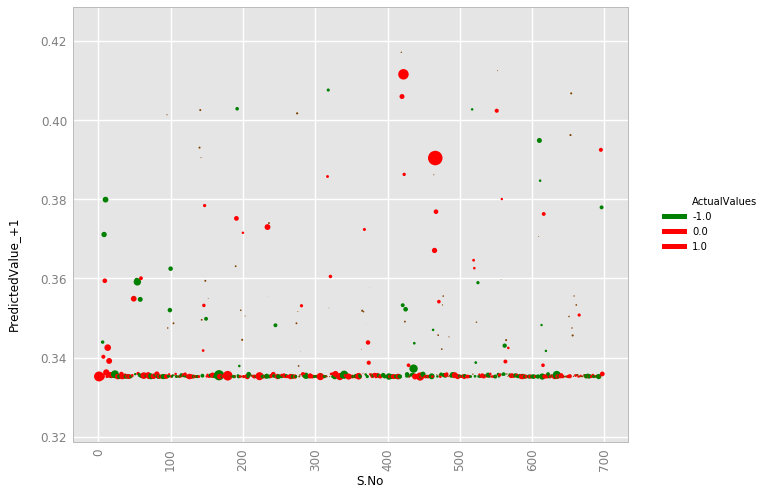

<ggplot: (-9223372029301740821)>

In [25]:
from ggplot import *
cbPalette = ["black", "red", "green"]
print(cbPalette)
p2 = ggplot(aes(x='S.No', y='PredictedValue_+1',color='ActualValues'), data=PredictedValues_DF)
p2 = p2 + geom_point(aes(size='NextDayPrcntChange')) + theme(axis_text_x = element_text(angle=90))
p2 = p2+ scale_color_gradient(low="green", high="red")
#p2 = p2 + scale_color_manual(values=cbPalette)
p2

Plot made from the predicted values shows that most of the times the model isn't extremely sure which way the price would shift on the next day. But when it *is* sure it does predict the right target class most of the times. 